# Saving and loading in DeepSensor

This notebook demonstrates how to use saving and loading functionality in DeepSensor. The three key DeepSensor classes: the `DataProcessor`, `TaskLoader`, and `ConvNP`, can all be saved and loaded. Internally, config files are used to track the state of each class, and these config files are saved alongside the model weights (for the `ConvNP`).

In [1]:
import logging
logging.captureWarnings(True)

import os

import deepsensor.torch
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.train.train import Trainer

import xarray as xr
import pandas as pd

In [2]:
folder = f"tmp_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(folder, exist_ok=True)

## Load raw data

In [3]:
ds_raw = xr.tutorial.open_dataset("air_temperature")

## Normalise/preprocess data

In [4]:
data_processor = DataProcessor(x1_name="lat", x2_name="lon")
ds = data_processor(ds_raw)

## NEW: Save normalised data for TaskLoader

In [5]:
t2m_fpath = f"{folder}/air_temperature_normalised.nc"
ds.to_netcdf(t2m_fpath)

## Set up TaskLoader

We must instantiate the `TaskLoader` with *paths* rather than the xarray object, so that the `TaskLoader` can be saved and loaded.

In [6]:
task_loader = TaskLoader(context=t2m_fpath, target=t2m_fpath)

## Set up ConvNP model

In [7]:
model = ConvNP(data_processor, task_loader, unet_channels=(32,)*3, verbose=False)

Train the model for a few iterations to test the trained model is restored correctly later.

In [8]:
task = task_loader("2014-12-31", 40, datewise_deterministic=True)
trainer = Trainer(model)
for _ in range(100):
    trainer([task])

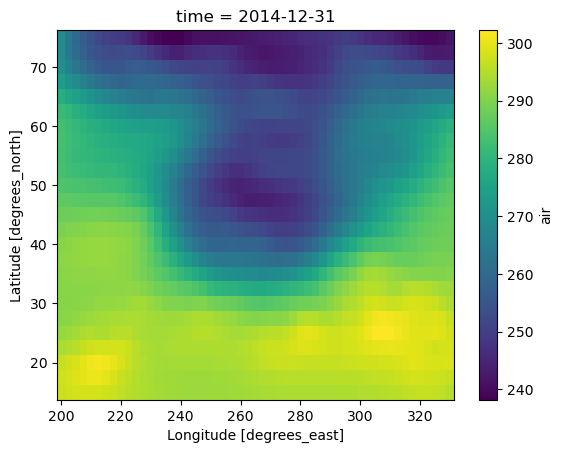

In [9]:
mean_ds_before, std_ds_before = model.predict(task, X_t=ds_raw)
mean_ds_before["air"].plot()

## Save the DataProcessor, TaskLoader, and ConvNP

In [10]:
data_processor.save(folder)
task_loader.save(folder)
model.save(folder)

## Load the DataProcessor, TaskLoader, and ConvNP

In [11]:
data_processor_loaded = DataProcessor(folder)
task_loader_loaded = TaskLoader(folder)
model_loaded = ConvNP(data_processor, task_loader, folder)

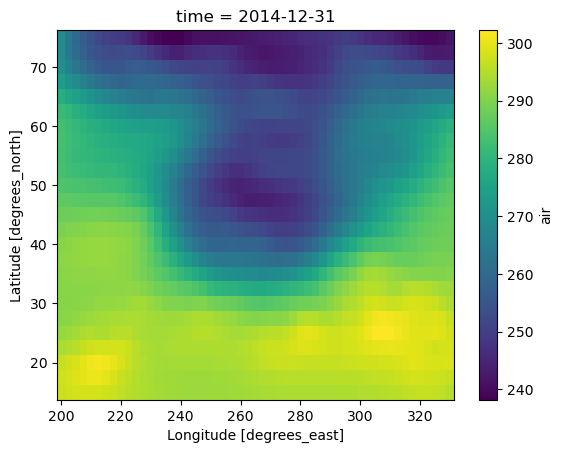

In [12]:
task = task_loader_loaded("2014-12-31", 40, datewise_deterministic=True)
mean_ds_loaded, std_ds_loaded = model_loaded.predict(task, X_t=ds_raw)
mean_ds_loaded["air"].plot()

In [13]:
xr.testing.assert_allclose(mean_ds_before, mean_ds_loaded)
print("Means match")

Means match


In [14]:
xr.testing.assert_allclose(std_ds_before, std_ds_loaded)
print("Standard deviations match")

Standard deviations match


## Delete temporary folder

In [15]:
import shutil
shutil.rmtree(folder)